# 🏠 ControlNet Floorplan Generator - Testing Notebook

**Test your trained model with upload/drawing before deploying!**

## What This Does:
- ✅ Load your trained ControlNet model
- ✅ Test with dataset samples (check overfitting)
- ✅ Upload your own segmentation masks
- ✅ Draw custom layouts interactively
- ✅ Generate variations & explore parameters
- ✅ Save results for your report

## Setup Instructions:
1. **Runtime → Change runtime type → T4 GPU** ⚡
2. Run cells in order from top to bottom
3. Wait for model loading (~2-3 minutes)
4. Start testing!

---

## 📦 Step 1: Install Dependencies

In [3]:
# === INSTALLATION - FIXED FOR COMPATIBILITY ===
# This fixes the 'cached_download' import error

import sys
print(f"Python version: {sys.version}\n")

# Clean install to avoid conflicts
print("🧹 Cleaning old packages...")
!pip uninstall -y diffusers transformers accelerate huggingface_hub -q

# Install latest compatible versions
print("📦 Installing compatible packages...")
!pip install -q diffusers>=0.27.0
!pip install -q transformers>=4.40.0
!pip install -q accelerate>=0.27.0
!pip install -q huggingface_hub>=0.20.0
!pip install -q gradio>=4.20.0
!pip install -q datasets

# Verify installation
print("\n🔍 Verifying installation...")
import torch
try:
    from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
    from transformers import __version__ as trans_ver
    from diffusers import __version__ as diff_ver
    print(f"✅ Diffusers: {diff_ver}")
    print(f"✅ Transformers: {trans_ver}")
    print(f"✅ PyTorch: {torch.__version__}")
    print(f"✅ CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print("\n🎉 Installation complete! You can proceed.")
except Exception as e:
    print(f"❌ Error: {e}")
    print("\n⚠️  If you see an error, click Runtime → Restart runtime, then re-run this cell.")


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

🧹 Cleaning old packages...
📦 Installing compatible packages...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, which is not installed.
peft 0.18.0 requires accelerate>=0.21.0, which is not installed.
peft 0.18.0 requires transformers, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.18.0 requires accelerate>=0.21.0, which is not installed.

🔍 Verifying installation...
✅ Diffusers: 0.36.0
✅ Transformers: 4.57.3
✅ PyTorch: 2.9.0+cpu
✅ CUDA available: False

🎉 Installation complete! You can proceed.


## 🤖 Step 2: Load Your Trained Model

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import gradio as gr
import random

print("🤖 Loading your trained ControlNet model...")
print("   This takes 2-3 minutes on first load")

# Load your trained ControlNet
controlnet = ControlNetModel.from_pretrained(
    "Qistinasofea/controlnet-floorplan",
    torch_dtype=torch.float16
)

# Load Stable Diffusion pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None
)

# Move to GPU and optimize memory
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)
pipe.enable_model_cpu_offload()
pipe.enable_attention_slicing()

print(f"\n✅ Model loaded successfully on {device}!")
print(f"   Memory optimizations enabled")

🤖 Loading your trained ControlNet model...
   This takes 2-3 minutes on first load


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

KeyboardInterrupt: 

## 🎨 Step 3: Define Room Colors & Generation Function

In [3]:
# Room color palette (matching your dataset)
ROOM_COLORS = {
    "Living Room": (255, 0, 0),       # Red
    "Bedroom": (0, 255, 0),           # Green
    "Kitchen": (0, 0, 255),           # Blue
    "Bathroom": (255, 255, 0),        # Yellow
    "Dining Room": (255, 0, 255),     # Magenta
    "Corridor": (0, 255, 255),        # Cyan
    "Balcony": (255, 165, 0),         # Orange
    "Closet": (128, 0, 128)           # Purple
}

print("🎨 Room Color Palette:")
for room, color in ROOM_COLORS.items():
    print(f"   {room:15s} → RGB{color}")

def generate_floorplan(
    segmentation_mask,
    prompt="a clean architectural floorplan with walls and rooms",
    num_inference_steps=20,
    controlnet_conditioning_scale=1.0,
    seed=42,
    show_comparison=True
):
    """
    Generate a floorplan from a segmentation mask.

    Args:
        segmentation_mask: PIL Image or numpy array (RGB)
        prompt: Text description
        num_inference_steps: Quality (10-50, higher=better/slower)
        controlnet_conditioning_scale: Layout strictness (0.5-2.0)
        seed: Random seed for reproducibility
        show_comparison: Display input vs output

    Returns:
        Generated PIL Image
    """
    # Prepare image
    if isinstance(segmentation_mask, np.ndarray):
        segmentation_mask = Image.fromarray(segmentation_mask)

    segmentation_mask = segmentation_mask.convert("RGB").resize((512, 512), Image.LANCZOS)

    # Generate
    generator = torch.Generator(device=device).manual_seed(seed)

    output = pipe(
        prompt=prompt,
        image=segmentation_mask,
        num_inference_steps=num_inference_steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=generator,
        guidance_scale=7.5
    )

    generated = output.images[0]

    # Display comparison
    if show_comparison:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].imshow(segmentation_mask)
        axes[0].set_title("Input Segmentation", fontsize=14, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(generated)
        axes[1].set_title("Generated Floorplan", fontsize=14, fontweight='bold')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    return generated

print("\n✅ Generation function ready!")

🎨 Room Color Palette:
   Living Room     → RGB(255, 0, 0)
   Bedroom         → RGB(0, 255, 0)
   Kitchen         → RGB(0, 0, 255)
   Bathroom        → RGB(255, 255, 0)
   Dining Room     → RGB(255, 0, 255)
   Corridor        → RGB(0, 255, 255)
   Balcony         → RGB(255, 165, 0)
   Closet          → RGB(128, 0, 128)

✅ Generation function ready!


## 🧪 Step 4: Test with Dataset Samples (Overfitting Check)

**This tests if your model is overfitting by comparing:**
- Input segmentation
- Generated floorplan (your model)
- Ground truth (training data)

**What to look for:**
- ✅ Generated matches input layout structure
- ✅ Generated is NOT identical to ground truth (overfitting sign)
- ✅ Generated has realistic architectural details

📊 Loading test samples from dataset...
Testing samples: [3331, 727, 9528]

Sample 1/3 (Dataset index: 3331)
Caption: a floor plan drawing, the rooms are used for the living room, kitchen, bedroom and bathroom,the furniture types are the chairs, the table, the sofa, the bed, the wardrobe, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the,


  0%|          | 0/20 [00:00<?, ?it/s]

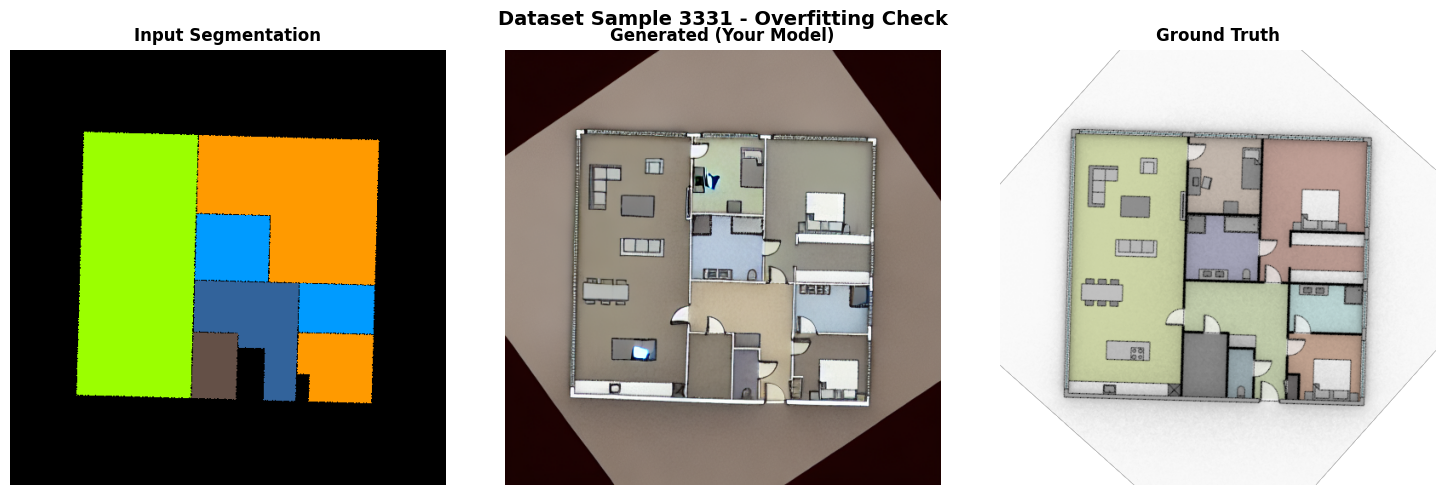


🔍 Evaluation Questions:
   ✅ Does generated match input layout?
   ✅ Is generated TOO similar to ground truth? (overfitting)
   ✅ Are walls/rooms in correct positions?

Sample 2/3 (Dataset index: 727)
Caption: a floor plan drawing, the rooms are used for the different types of meetings,,


  0%|          | 0/20 [00:00<?, ?it/s]

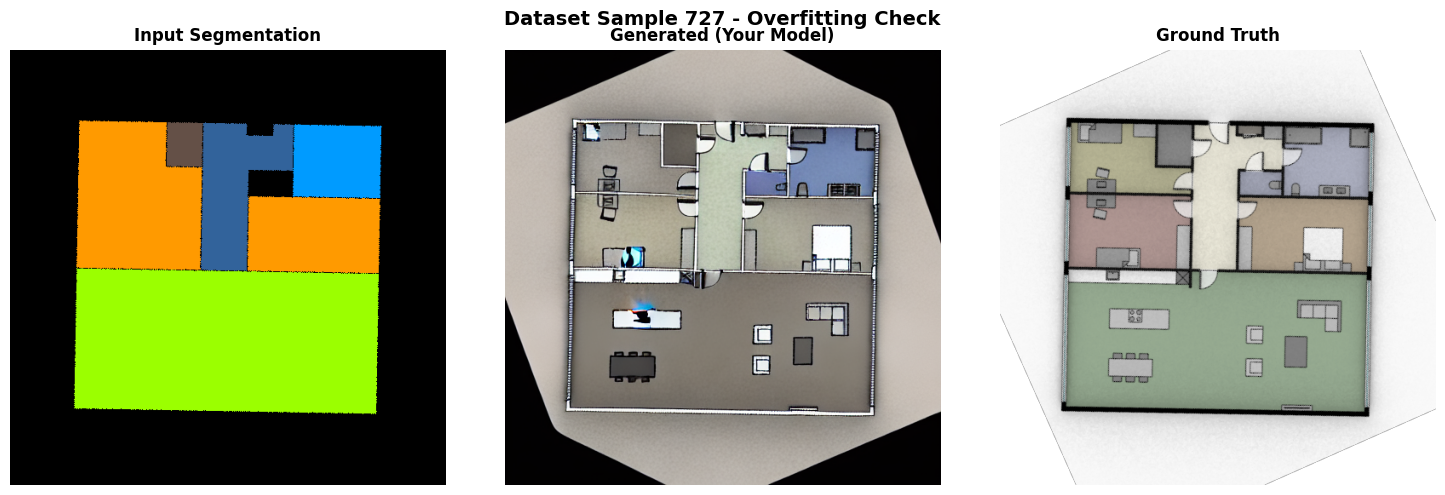


🔍 Evaluation Questions:
   ✅ Does generated match input layout?
   ✅ Is generated TOO similar to ground truth? (overfitting)
   ✅ Are walls/rooms in correct positions?

Sample 3/3 (Dataset index: 9528)
Caption: a floor plan drawing, the rooms are used for the living room, kitchen, bedroom, bathroom, and office,the furniture types are the chairs, the table, the sofa, the bed, the wardrobe, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the,


  0%|          | 0/20 [00:00<?, ?it/s]

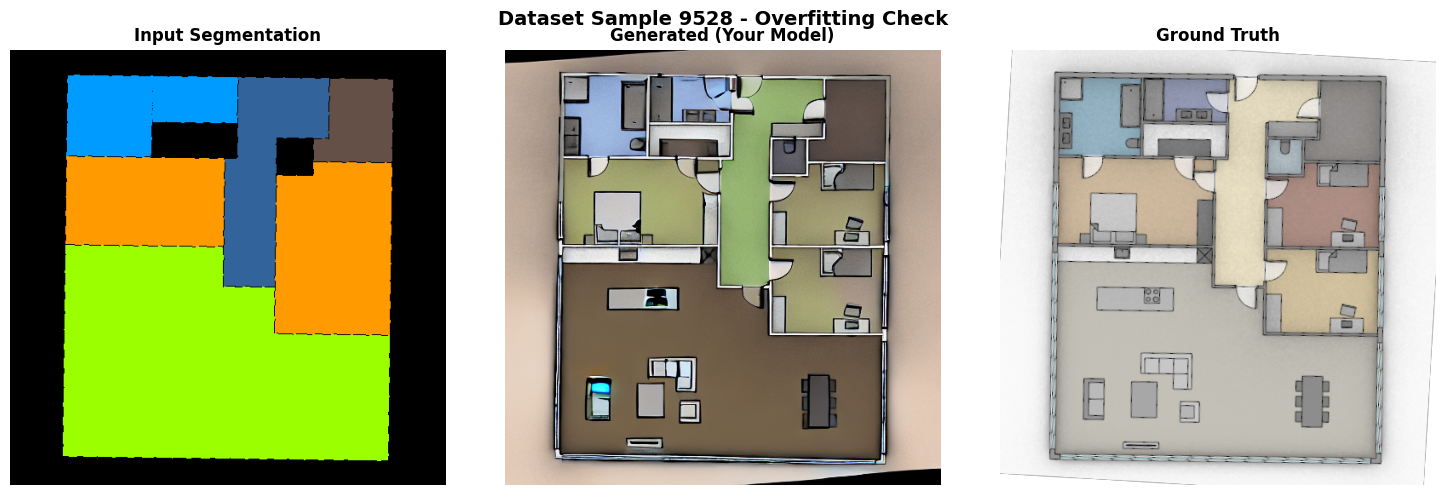


🔍 Evaluation Questions:
   ✅ Does generated match input layout?
   ✅ Is generated TOO similar to ground truth? (overfitting)
   ✅ Are walls/rooms in correct positions?


✅ Dataset testing complete!


In [6]:
# Load dataset
print("📊 Loading test samples from dataset...")
dataset = load_dataset("Qistinasofea/floorplan-12k-aligned", split="train")

# Test 3 random samples
test_indices = random.sample(range(len(dataset)), 3)
print(f"Testing samples: {test_indices}\n")

for i, idx in enumerate(test_indices):
    sample = dataset[idx]

    print(f"{'='*70}")
    print(f"Sample {i+1}/3 (Dataset index: {idx})")
    print(f"Caption: {sample['captions']}")
    print(f"{'='*70}")

    # Generate
    generated = generate_floorplan(
        segmentation_mask=sample['colors'],
        prompt=sample['captions'],
        seed=42,
        show_comparison=False
    )

    # Display: Input → Generated → Ground Truth
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(sample['colors'])
    axes[0].set_title("Input Segmentation", fontsize=12, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(generated)
    axes[1].set_title("Generated (Your Model)", fontsize=12, fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(sample['plans'])
    axes[2].set_title("Ground Truth", fontsize=12, fontweight='bold')
    axes[2].axis('off')

    plt.suptitle(f"Dataset Sample {idx} - Overfitting Check", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n🔍 Evaluation Questions:")
    print("   ✅ Does generated match input layout?")
    print("   ✅ Is generated TOO similar to ground truth? (overfitting)")
    print("   ✅ Are walls/rooms in correct positions?\n")

print("\n✅ Dataset testing complete!")

## 🎨 Step 5: Create Custom Layouts Programmatically

Test your model on layouts it has NEVER seen before!

🏠 Test 1: Simple 2-Bedroom Apartment


  0%|          | 0/20 [00:00<?, ?it/s]

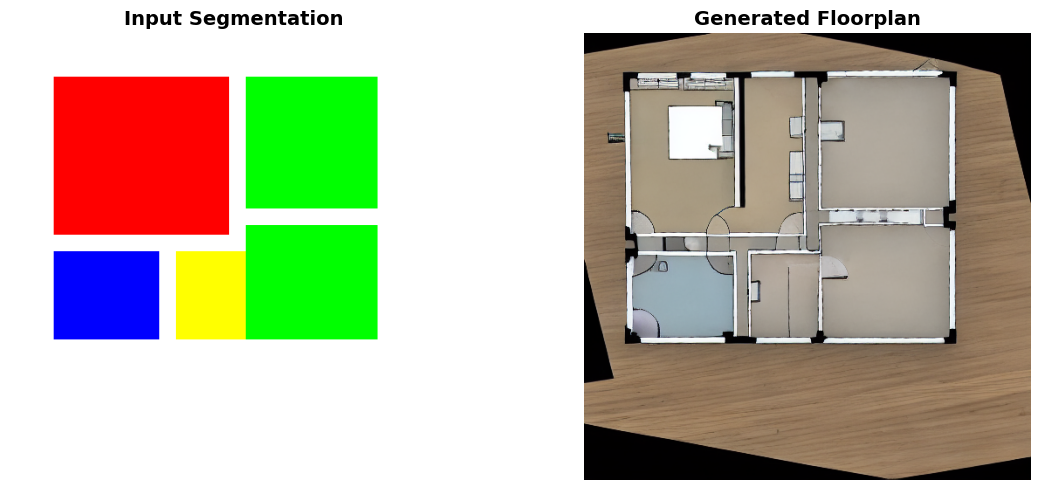


🏠 Test 2: Studio Apartment


  0%|          | 0/20 [00:00<?, ?it/s]

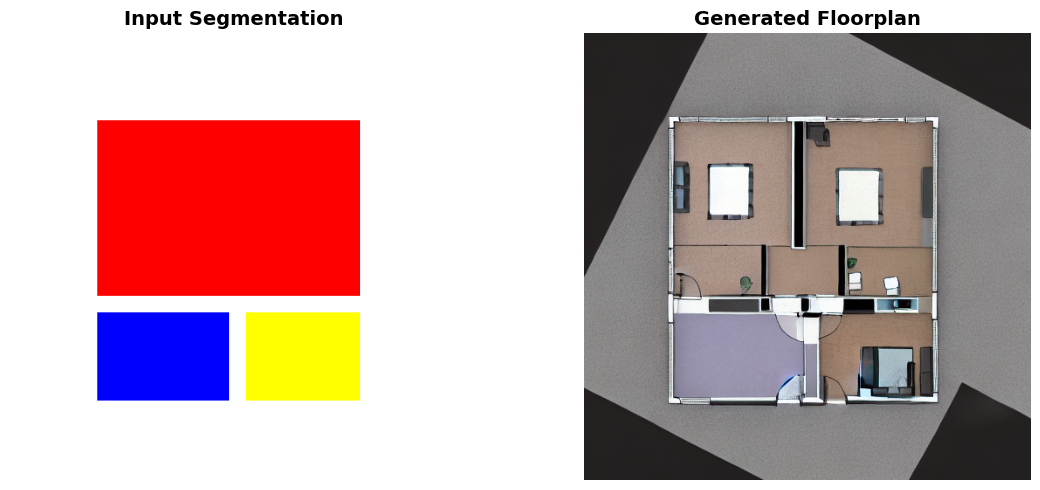


🏠 Test 3: Complex Multi-Room House


  0%|          | 0/20 [00:00<?, ?it/s]

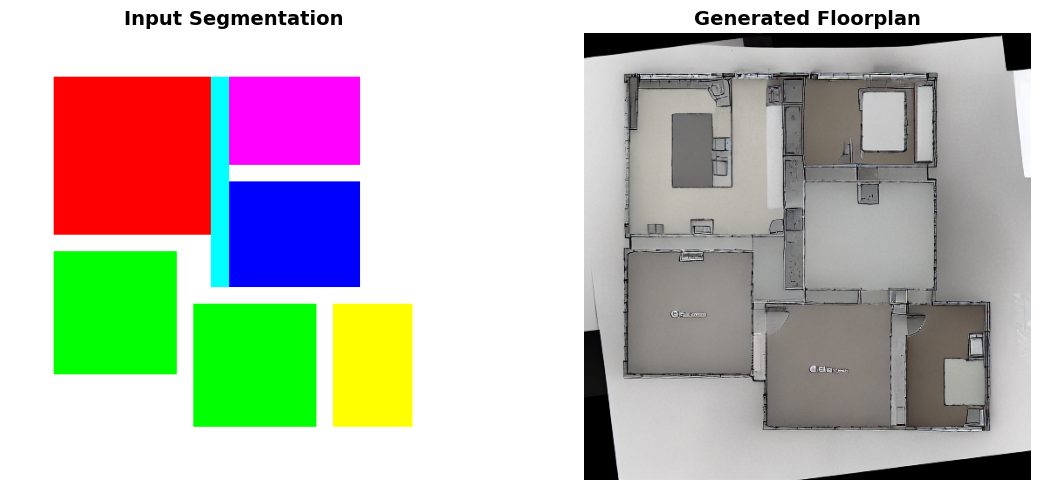


✅ Custom layouts tested!


In [7]:
def create_simple_layout(rooms_config):
    """
    Create a segmentation mask programmatically.

    Args:
        rooms_config: List of (room_name, x, y, width, height)
    """
    img = Image.new('RGB', (512, 512), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)

    for room_name, x, y, w, h in rooms_config:
        color = ROOM_COLORS.get(room_name, (128, 128, 128))
        draw.rectangle([x, y, x+w, y+h], fill=color)

    return img

# Test Layout 1: Simple 2-Bedroom Apartment
print("🏠 Test 1: Simple 2-Bedroom Apartment")
layout1 = create_simple_layout([
    ("Living Room", 50, 50, 200, 180),
    ("Bedroom", 270, 50, 150, 150),
    ("Kitchen", 50, 250, 120, 100),
    ("Bathroom", 190, 250, 80, 100),
    ("Bedroom", 270, 220, 150, 130)
])
generated1 = generate_floorplan(layout1, seed=42)

# Test Layout 2: Studio Apartment
print("\n🏠 Test 2: Studio Apartment")
layout2 = create_simple_layout([
    ("Living Room", 100, 100, 300, 200),
    ("Kitchen", 100, 320, 150, 100),
    ("Bathroom", 270, 320, 130, 100)
])
generated2 = generate_floorplan(layout2, seed=123)

# Test Layout 3: Complex Multi-Room House
print("\n🏠 Test 3: Complex Multi-Room House")
layout3 = create_simple_layout([
    ("Living Room", 50, 50, 180, 180),
    ("Dining Room", 250, 50, 150, 100),
    ("Kitchen", 250, 170, 150, 120),
    ("Corridor", 230, 50, 20, 240),
    ("Bedroom", 50, 250, 140, 140),
    ("Bedroom", 210, 310, 140, 140),
    ("Bathroom", 370, 310, 90, 140)
])
generated3 = generate_floorplan(layout3, seed=456)

print("\n✅ Custom layouts tested!")

## 🔄 Step 6: Test Diversity (Multiple Seeds)

**Check if your model generates diverse outputs or just memorized patterns**

🔄 Generating 4 variations with different seeds...



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

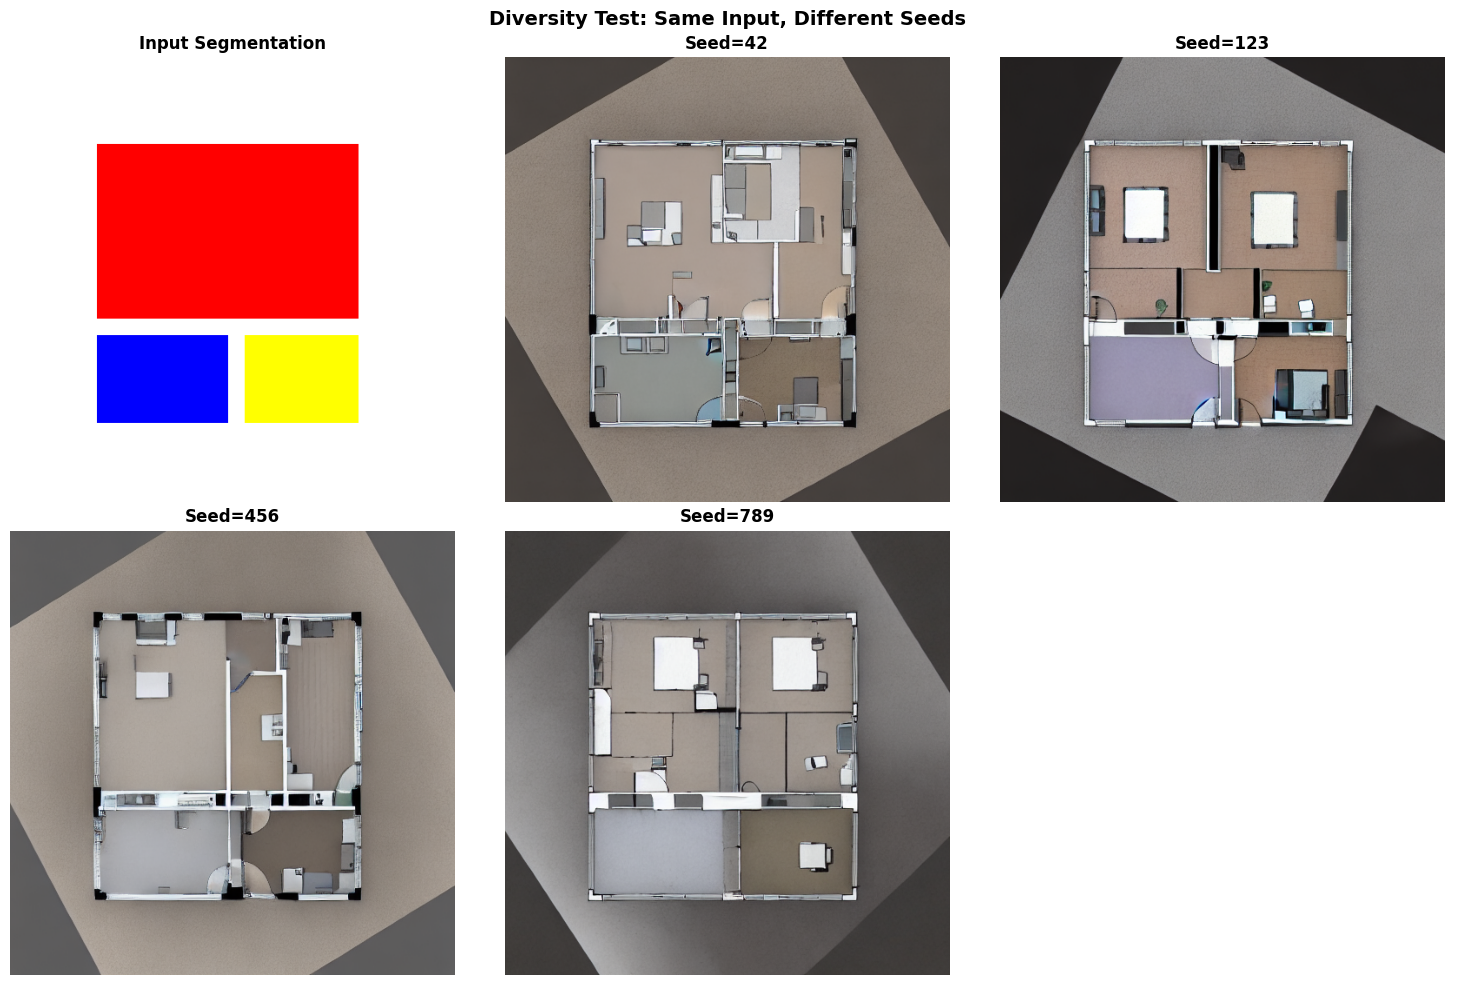


🔍 Evaluation:
   ✅ Good: Outputs show variation (different details, styles)
   ⚠️  Bad: All outputs nearly identical (overfitting sign)


In [8]:
print("🔄 Generating 4 variations with different seeds...\n")

test_layout = layout2  # Use studio apartment
seeds = [42, 123, 456, 789]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Show input
axes[0].imshow(test_layout)
axes[0].set_title("Input Segmentation", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Generate variations
for i, seed in enumerate(seeds):
    generated = generate_floorplan(
        segmentation_mask=test_layout,
        seed=seed,
        show_comparison=False
    )

    axes[i+1].imshow(generated)
    axes[i+1].set_title(f"Seed={seed}", fontsize=12, fontweight='bold')
    axes[i+1].axis('off')

# Hide last subplot
axes[5].axis('off')

plt.suptitle("Diversity Test: Same Input, Different Seeds", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Evaluation:")
print("   ✅ Good: Outputs show variation (different details, styles)")
print("   ⚠️  Bad: All outputs nearly identical (overfitting sign)")

## 🔬 Step 7: Explore Conditioning Scale

**Test how strictly the model follows your input layout**

🔬 Testing conditioning scale (layout strictness)...



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

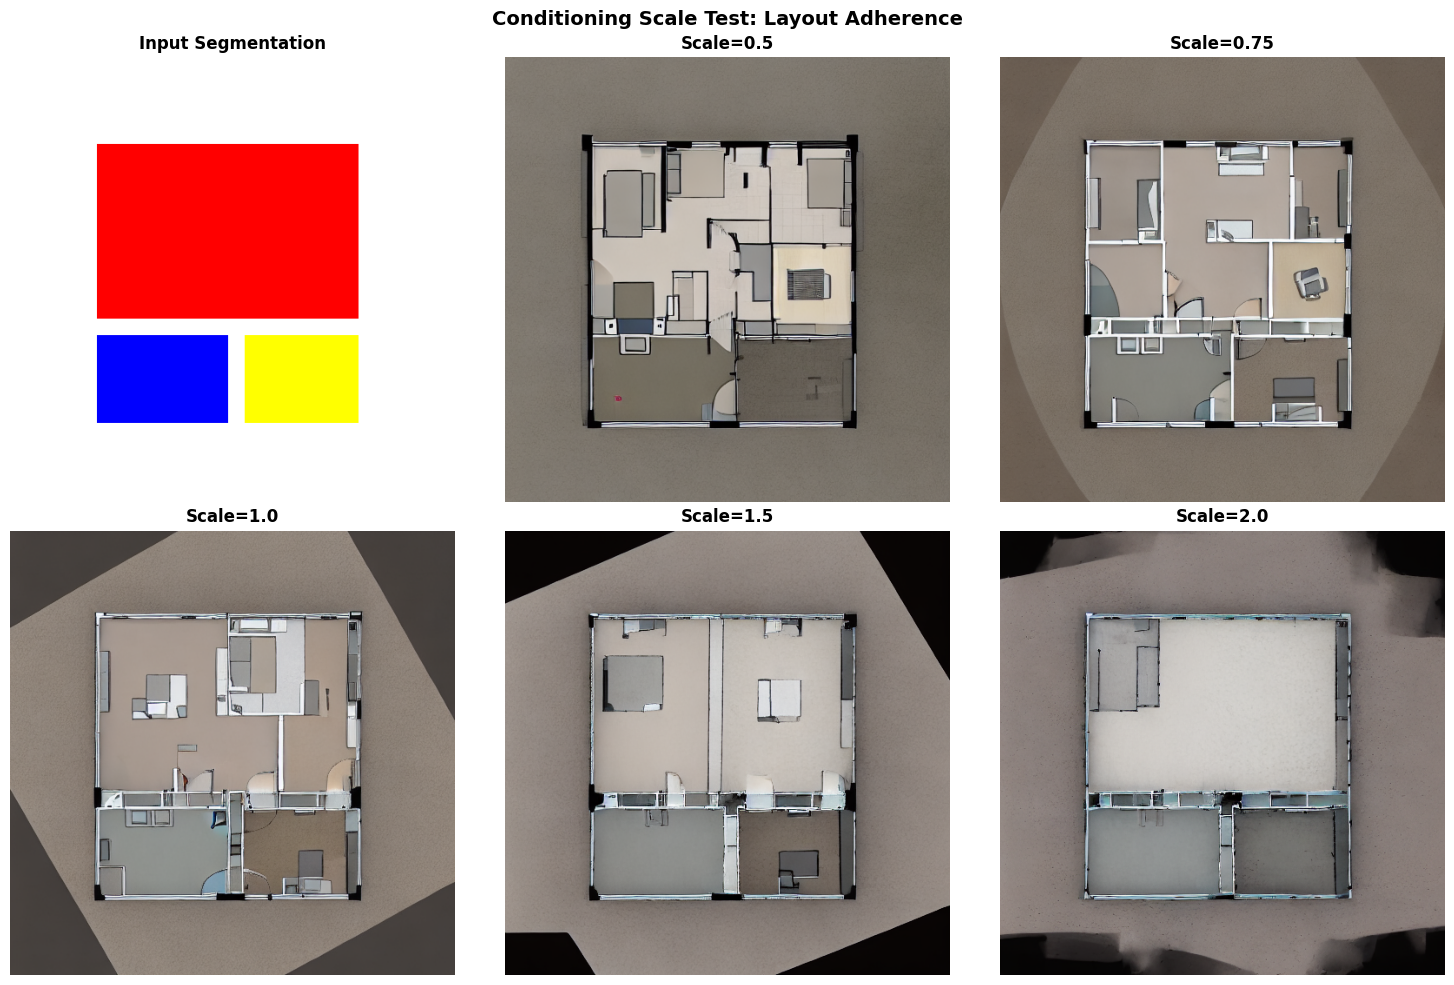


🔍 Expected Behavior:
   • Scale 0.5: More creative freedom, looser layout
   • Scale 1.0: Balanced (default)
   • Scale 2.0: Stricter layout adherence


In [9]:
print("🔬 Testing conditioning scale (layout strictness)...\n")

scales = [0.5, 0.75, 1.0, 1.5, 2.0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Show input
axes[0].imshow(test_layout)
axes[0].set_title("Input Segmentation", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Test different scales
for i, scale in enumerate(scales):
    generated = generate_floorplan(
        segmentation_mask=test_layout,
        controlnet_conditioning_scale=scale,
        seed=42,
        show_comparison=False
    )

    axes[i+1].imshow(generated)
    axes[i+1].set_title(f"Scale={scale}", fontsize=12, fontweight='bold')
    axes[i+1].axis('off')

plt.suptitle("Conditioning Scale Test: Layout Adherence", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Expected Behavior:")
print("   • Scale 0.5: More creative freedom, looser layout")
print("   • Scale 1.0: Balanced (default)")
print("   • Scale 2.0: Stricter layout adherence")

## 🎨 Step 8: Interactive Drawing Interface (GRADIO)

**Upload your own images OR draw layouts interactively!**

This launches a web interface where you can:
- Draw colored room layouts with a brush
- Upload your own segmentation mask images
- Adjust generation parameters
- Get instant results

**The interface will provide a public URL you can access on your phone!**

In [1]:
# ========================================================================
# IMMEDIATE FIX - Copy and Run This in a New Cell Right Now
# ========================================================================
# This fixes the "controlnet_conditioning_scale must be type float" error
# Just copy this entire block and run it in your current Colab session

def gradio_generate(image_dict, prompt, steps, scale, seed):
    """Fixed Gradio wrapper with proper type conversion."""
    if image_dict is None:
        return None

    try:
        # Extract image
        if isinstance(image_dict, dict) and 'composite' in image_dict:
            img = image_dict['composite']
        else:
            img = image_dict

        # FIX: Convert parameters to correct types
        steps = int(steps)
        scale = float(scale)    # THIS IS THE CRITICAL FIX!
        seed = int(seed)

        # Generate
        result = generate_floorplan(
            segmentation_mask=img,
            prompt=str(prompt),
            num_inference_steps=steps,
            controlnet_conditioning_scale=scale,
            seed=seed,
            show_comparison=False
        )

        return result

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Now re-launch the Gradio interface with the fixed function
import gradio as gr

with gr.Blocks(title="ControlNet Floorplan Tester") as demo:
    gr.Markdown("""
    # 🏠 ControlNet Floorplan Generator - Interactive Testing (FIXED)

    **The type error has been fixed! Draw or upload your layouts.**

    1. **Draw**: Use colored brush to draw room layouts
    2. **Upload**: Upload an image (PNG/JPG)
    3. **Generate**: Click button and wait ~10-15 seconds
    """)

    with gr.Row():
        with gr.Column():
            input_image = gr.ImageEditor(
                label="Draw or Upload Segmentation Mask",
                type="pil",
                brush=gr.Brush(
                    colors=[
                        "#FF0000",  # Living Room (Red)
                        "#00FF00",  # Bedroom (Green)
                        "#0000FF",  # Kitchen (Blue)
                        "#FFFF00",  # Bathroom (Yellow)
                        "#FF00FF",  # Dining Room (Magenta)
                        "#00FFFF",  # Corridor (Cyan)
                        "#FFA500",  # Balcony (Orange)
                        "#800080"   # Closet (Purple)
                    ],
                    default_size=30
                ),
                height=512
            )

            prompt = gr.Textbox(
                label="Prompt",
                value="a clean architectural floorplan with walls and rooms"
            )

            with gr.Row():
                steps = gr.Slider(10, 50, 20, step=1, label="Steps")
                scale = gr.Slider(0.5, 2.0, 1.0, step=0.1, label="Scale")

            seed = gr.Slider(0, 999999, 42, step=1, label="Seed")
            generate_btn = gr.Button("🚀 Generate Floorplan", variant="primary", size="lg")

        with gr.Column():
            output_image = gr.Image(label="Generated Floorplan", type="pil")

    gr.Markdown("""
    ### 🎨 Color Legend:
    - 🔴 Red: Living Room
    - 🟢 Green: Bedroom
    - 🔵 Blue: Kitchen
    - 🟡 Yellow: Bathroom
    - 🟪 Magenta: Dining Room
    - 🟦 Cyan: Corridor
    - 🟠 Orange: Balcony
    - 🟣 Purple: Closet

    ### 💡 Tips:
    - Draw clear rectangular regions
    - Use larger brush for bigger rooms
    - Try different seeds for variations
    - Higher scale = stricter layout adherence
    """)

    generate_btn.click(
        fn=gradio_generate,
        inputs=[input_image, prompt, steps, scale, seed],
        outputs=output_image
    )

# Launch!
demo.launch(share=True, debug=True)

print("\n✅ Interface launched!")
print("📱 Use the public URL to test on your phone or share with others")
print("🎨 Upload images OR draw directly on the canvas")
print("💾 Right-click generated images to save them")

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7d0318999ad26df828.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


❌ Error: name 'generate_floorplan' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-4135336396.py", line 25, in gradio_generate
    result = generate_floorplan(
             ^^^^^^^^^^^^^^^^^^
NameError: name 'generate_floorplan' is not defined


❌ Error: name 'generate_floorplan' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-4135336396.py", line 25, in gradio_generate
    result = generate_floorplan(
             ^^^^^^^^^^^^^^^^^^
NameError: name 'generate_floorplan' is not defined


❌ Error: name 'generate_floorplan' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-4135336396.py", line 25, in gradio_generate
    result = generate_floorplan(
             ^^^^^^^^^^^^^^^^^^
NameError: name 'generate_floorplan' is not defined


❌ Error: name 'generate_floorplan' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-4135336396.py", line 25, in gradio_generate
    result = generate_floorplan(
             ^^^^^^^^^^^^^^^^^^
NameError: name 'generate_floorplan' is not defined


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7d0318999ad26df828.gradio.live

✅ Interface launched!
📱 Use the public URL to test on your phone or share with others
🎨 Upload images OR draw directly on the canvas
💾 Right-click generated images to save them


## 💾 Step 9: Save Results for Report (Optional)

Generate a comprehensive comparison grid for your AI54 report Section 5.2

In [1]:
import matplotlib.pyplot as plt
import numpy as np

print("💾 Generating report-ready comparison grid...\n")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Different seeds
print("Generating seed variations...")
seeds = [42, 123, 456, 789]
for i, seed in enumerate(seeds):
    if i == 0:
        axes[0, i].imshow(layout3)
        axes[0, i].set_title("Input", fontsize=11, fontweight='bold')
    else:
        generated = generate_floorplan(
            segmentation_mask=layout3,
            seed=seed,
            show_comparison=False
        )
        axes[0, i].imshow(generated)
        axes[0, i].set_title(f"Seed={seed}", fontsize=11, fontweight='bold')
    axes[0, i].axis('off')

# Row 2: Different conditioning scales
print("Generating scale variations...")
scales = [0.5, 1.0, 1.5, 2.0]
for i, scale in enumerate(scales):
    generated = generate_floorplan(
        segmentation_mask=layout3,
        controlnet_conditioning_scale=scale,
        seed=42,
        show_comparison=False
    )
    axes[1, i].imshow(generated)
    axes[1, i].set_title(f"Scale={scale}", fontsize=11, fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle("Model Testing: Seed Variations & Conditioning Scale Exploration",
             fontsize=14, fontweight='bold')
plt.tight_layout()

# Save
output_path = "ai54_section_5_2_comparison_grid.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved to: {output_path}")
print("📄 Use this image in your report Section 5.2!")
print("💾 Download it from Colab Files panel (left sidebar)")

💾 Generating report-ready comparison grid...



NameError: name 'plt' is not defined

## 📋 Step 10: Evaluation Checklist

Review your results against these criteria:

In [ ]:
print("""
╔════════════════════════════════════════════════════════════════════╗
║              MODEL EVALUATION CHECKLIST                            ║
╚════════════════════════════════════════════════════════════════════╝

✅ LAYOUT PRESERVATION:
   □ Generated rooms match input color positions?
   □ Room boundaries are clear and accurate?
   □ Walls align with segmentation edges?

✅ DIVERSITY CHECK (Step 6):
   □ Different seeds produce varied outputs?
   □ Or are outputs too similar? (overfitting sign)

✅ QUALITY ASSESSMENT:
   □ Floorplans look realistic and architectural?
   □ Include walls, doors, windows?
   □ Style consistent with training data?

✅ GENERALIZATION (Step 5):
   □ Works on custom layouts NOT in training?
   □ Handles unusual configurations?
   □ Fails gracefully on edge cases?

✅ PARAMETER SENSITIVITY (Step 7):
   □ Conditioning scale works as expected?
   □ Higher scale = stricter layout?
   □ Lower scale = more freedom?

✅ OVERFITTING SIGNS (Step 4):
   □ Generated too similar to ground truth?
   □ Model memorizing specific layouts?
   □ Poor on novel configurations?

═══════════════════════════════════════════════════════════════════

🎯 Summary:
- Review all outputs above
- Test more layouts in Gradio (Step 8)
- Save best examples for report
- Document any limitations

Ready to deploy to HuggingFace Spaces? ✅
""")

---

## 🎉 Testing Complete!

### What You've Done:
1. ✅ Tested model on dataset samples (overfitting check)
2. ✅ Created and tested custom layouts
3. ✅ Checked output diversity with different seeds
4. ✅ Explored conditioning scale effects
5. ✅ Launched interactive drawing interface
6. ✅ Generated comparison grid for report

### Next Steps:
- **Keep the Gradio interface running** to test more layouts
- **Download generated images** for your report
- **Document findings** in Section 5.2
- **Deploy to HuggingFace Spaces** when satisfied!

### For Your Report (Section 5.2):
Include:
- Comparison grid from Step 9
- Example inputs and outputs
- Discussion of layout preservation
- Any limitations observed

---

**Model Repository:** [Qistinasofea/controlnet-floorplan](https://huggingface.co/Qistinasofea/controlnet-floorplan)  
**Dataset:** [zimhe/pseudo-floor-plan-12k](https://huggingface.co/datasets/zimhe/pseudo-floor-plan-12k)  
**Training:** 10,000 steps, loss 0.0887, 3h42m on T4 GPU